# Improved notebook to download buildings from Microsoft

This notebook works with the [Microsoft Building Footprint Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints) to download building footprints for a given area of interest (AOI). I modiefied the [original notebook](https://github.com/victor-ka-ming-fung/GlobalMLBuildingFootprints/blob/main/examples/example_building_footprints.ipynb) to download the data to output a parquet file of a geodataframe of buildings, instead of GeoJSON.

In [1]:
# # """install packages if not already installed"""
# %pip install --upgrade pandas geopandas shapely mercantile tqdm folium

In [2]:
import pandas as pd
import geopandas as gpd
import shapely.geometry
import mercantile
from tqdm import tqdm

## Step 1 - Define our area of interest (AOI)

We define our area of interest (or AOI) as a GeoJSON geometry, then use the `shapely` library to get the bounding box.

**Note**: the coordinate reference system for the GeoJSON should be "EPSG:4326", i.e. in global lat/lon format.

In [3]:
# Geometry copied from https://geojson.io
aoi_geom = {
    "coordinates": [
        [
            [-122.16484503187519, 47.69090474454916],
            [-122.16484503187519, 47.6217555345674],
            [-122.06529607517405, 47.6217555345674],
            [-122.06529607517405, 47.69090474454916],
            [-122.16484503187519, 47.69090474454916],
        ]
    ],
    "type": "Polygon",
}
aoi_shape = shapely.geometry.shape(aoi_geom)
minx, miny, maxx, maxy = aoi_shape.bounds

output_fn = "example_building_footprints.parquet"

## Step 2 - Determine which tiles intersect our AOI

In [4]:
"""Get tiles for a given bounding box and zoom level"""

quad_keys = set()
for tile in list(mercantile.tiles(minx, miny, maxx, maxy, zooms=9)):
    quad_keys.add(int(mercantile.quadkey(tile)))

quad_keys = list(quad_keys)

print(f"The input area spans {len(quad_keys)} tiles: {quad_keys}")

The input area spans 1 tiles: [21230030]


## Step 3 - Download the building footprints for each tile that intersects our AOI and crop the results

This is where most of the magic happens. We download all the building footprints for each tile that intersects our AOI, then only keep the footprints that are _contained_ by our AOI.

*Note*: this step might take awhile depending on how many tiles your AOI covers and how many buildings footprints are in those tiles.

In [5]:
# read the quads catalog
df = pd.read_csv(
    "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv"
)

# extract urls for the quads we want
urls = df.pipe(lambda x: x[x["QuadKey"].isin(quad_keys)])["Url"].unique()

# download the quads and read as one consolidated pandas dataframe
buildings_df_list = [pd.read_json(url, lines=True) for url in tqdm(urls)]

# concatenate the list of dataframes
buildings_df = pd.concat(buildings_df_list)

# concvert to geopandas dataframe
buildings_gdf = (
    buildings_df.pipe(
        lambda x: gpd.GeoDataFrame(
            data=x,
            crs=4326,
            geometry=x["geometry"].apply(shapely.geometry.shape),
        )
    )
    # retain the height information
    .assign(
        height_m=lambda x: x["properties"].apply(
            lambda p: p["height"],
        ),
    )
    # drop the raw column for height and type
    .drop(
        columns=[
            "properties",
            "type",
        ],
        errors="ignore",
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# filter to buildings that intersect the AOI
buildings_in_aoi_gdf = buildings_gdf[buildings_gdf.intersects(aoi_shape)]

# Step 4 - Save the resulting footprints to a parquet file

In [ ]:
# write to parquet
buildings_in_aoi_gdf.to_parquet(output_fn)

# Optional sense check

In [ ]:
# interactive map
# import folium

# m = buildings_in_aoi_gdf.explore(
#     attr="Google",
#     tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
# )

# folium.TileLayer("OpenStreetMap").add_to(m)

# folium.LayerControl().add_to(m)

# m

<Axes: >

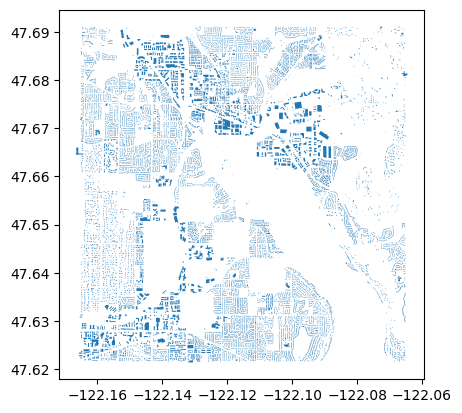

In [ ]:
# static map
buildings_in_aoi_gdf.plot()